In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/
%cd /content/lag-llama
!pip install -r requirements.txt --quiet

Cloning into 'lag-llama'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 272 (delta 93), reused 75 (delta 75), pack-reused 162
Receiving objects: 100% (272/272), 218.53 KiB | 8.40 MiB/s, done.
Resolving deltas: 100% (134/134), done.
/content/lag-llama
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 95.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 108.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 24.8 MB/s eta 0:0

In [2]:
pip install gluonts[torch]==0.14.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: gluonts
    Found existing installation: gluonts 0.15.1
    Uninstalling gluonts-0.15.1:
      Successfully uninstalled gluonts-0.15.1


In [3]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 92.1MB/s]
Download complete. Moving file to /content/lag-llama/lag-llama.ckpt
/content/lag-llama/lag-llama.ckpt


In [15]:
from itertools import islice

import matplotlib.dates as mdates
import pandas as pd
import torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from lag_llama.gluon.estimator import LagLlamaEstimator
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

In [6]:
pip install yfinance==0.2.37

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.40
    Uninstalling yfinance-0.2.40:
      Successfully uninstalled yfinance-0.2.40


In [7]:
import yfinance as yf


# adjust the tickers, period, and frequency as needed
stock_prices = (
    yf.Tickers("aapl amd amzn crm goog meta msft nvda tsla")
    .history(period="max", start="2013-01-01")
    .Close
    .resample('1d')
    .ffill()
)
stock_prices

[*********************100%%**********************]  9 of 9 completed


Ticker,AAPL,AMD,AMZN,CRM,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,,,
2013-01-02,16.747725,2.530000,12.865500,42.736675,17.993254,27.942579,22.492281,0.293560,2.357333
2013-01-03,16.536329,2.490000,12.924000,42.122478,18.003704,27.713053,22.190973,0.293791,2.318000
2013-01-04,16.075720,2.590000,12.957500,42.347183,18.359463,28.701021,21.775654,0.303484,2.293333
2013-01-05,16.075720,2.590000,12.957500,42.347183,18.359463,28.701021,21.775654,0.303484,2.293333
2013-01-06,16.075720,2.590000,12.957500,42.347183,18.359463,28.701021,21.775654,0.303484,2.293333
...,...,...,...,...,...,...,...,...,...
2024-06-10,193.119995,160.339996,187.059998,241.839996,176.630005,502.101501,427.869995,121.779999,173.789993
2024-06-11,207.149994,158.960007,187.229996,240.990005,178.190002,506.966644,432.679993,120.910004,170.660004
2024-06-12,213.070007,160.240005,186.889999,235.800003,179.559998,508.335297,441.059998,125.199997,177.289993


In [8]:
stock_returns = stock_prices.rolling(5).mean().pct_change().dropna()

In [9]:
stock_returns

Ticker,AAPL,AMD,AMZN,CRM,GOOG,META,MSFT,NVDA,TSLA
Date,,,,,,,,,
2013-01-07,-0.009404,0.010946,0.008622,-0.002580,0.003141,0.009996,-0.006884,0.000770,-0.005885
2013-01-08,-0.006343,0.013921,0.006056,0.001488,0.002622,0.008991,-0.005218,-0.003695,-0.006326
2013-01-09,-0.003764,0.003051,0.005487,0.002619,0.000041,0.012642,-0.000300,-0.014526,-0.004439
2013-01-10,-0.001332,0.002281,0.004691,0.004129,0.000953,0.017327,-0.002099,-0.014427,-0.005104
2013-01-11,-0.002560,0.006070,0.006631,0.004382,0.000548,0.019848,0.000676,-0.014956,-0.008786
...,...,...,...,...,...,...,...,...,...
2024-06-10,-0.002803,-0.006969,0.006288,0.004407,-0.000271,0.003055,0.001821,-0.001072,-0.001367
2024-06-11,0.012951,-0.009413,0.002411,-0.001463,0.000048,0.005539,0.003842,-0.000129,-0.008234
2024-06-12,0.016328,-0.009272,0.002793,-0.005007,0.004319,0.006380,0.008072,0.007140,-0.000217


In [144]:
def _get_lag_llama_dataset(dataset):
    # avoid mutations
    dataset = dataset.copy()

    # convert numerical columns to `float32`
    for col in dataset.columns:
        if dataset[col].dtype != "object" and not pd.api.types.is_string_dtype(
            dataset[col]
        ):
            dataset[col] = dataset[col].astype("float32")

    # create a `PandasDataset`
    backtest_dataset = PandasDataset(dict(dataset))
    return backtest_dataset


backtest_dataset = _get_lag_llama_dataset(dataset=stock_returns)
prediction_length = 60 # prediction length
num_samples = 1060 # sampled from the distribution for each timestep

In [145]:
from gluonts.dataset.util import to_pandas
entry = next(iter(backtest_dataset))
train_series = to_pandas(entry)
train_series

2013-01-07   -0.009404
2013-01-08   -0.006343
2013-01-09   -0.003764
2013-01-10   -0.001332
2013-01-11   -0.002560
                ...   
2024-06-10   -0.002803
2024-06-11    0.012951
2024-06-12    0.016328
2024-06-13    0.017227
2024-06-14    0.015227
Freq: D, Length: 4177, dtype: float32

In [146]:
len(stock_returns)

4177

In [147]:
forecasts, tss = _get_lag_llama_predictions(
    backtest_dataset, prediction_length, num_samples
)

Forecasting batches:   0%|          | 0/9 [00:00<?, ?it/s]

Ground truth:   0%|          | 0/9 [00:00<?, ?it/s]

In [148]:
forecasts[0].samples.shape

(1060, 60)

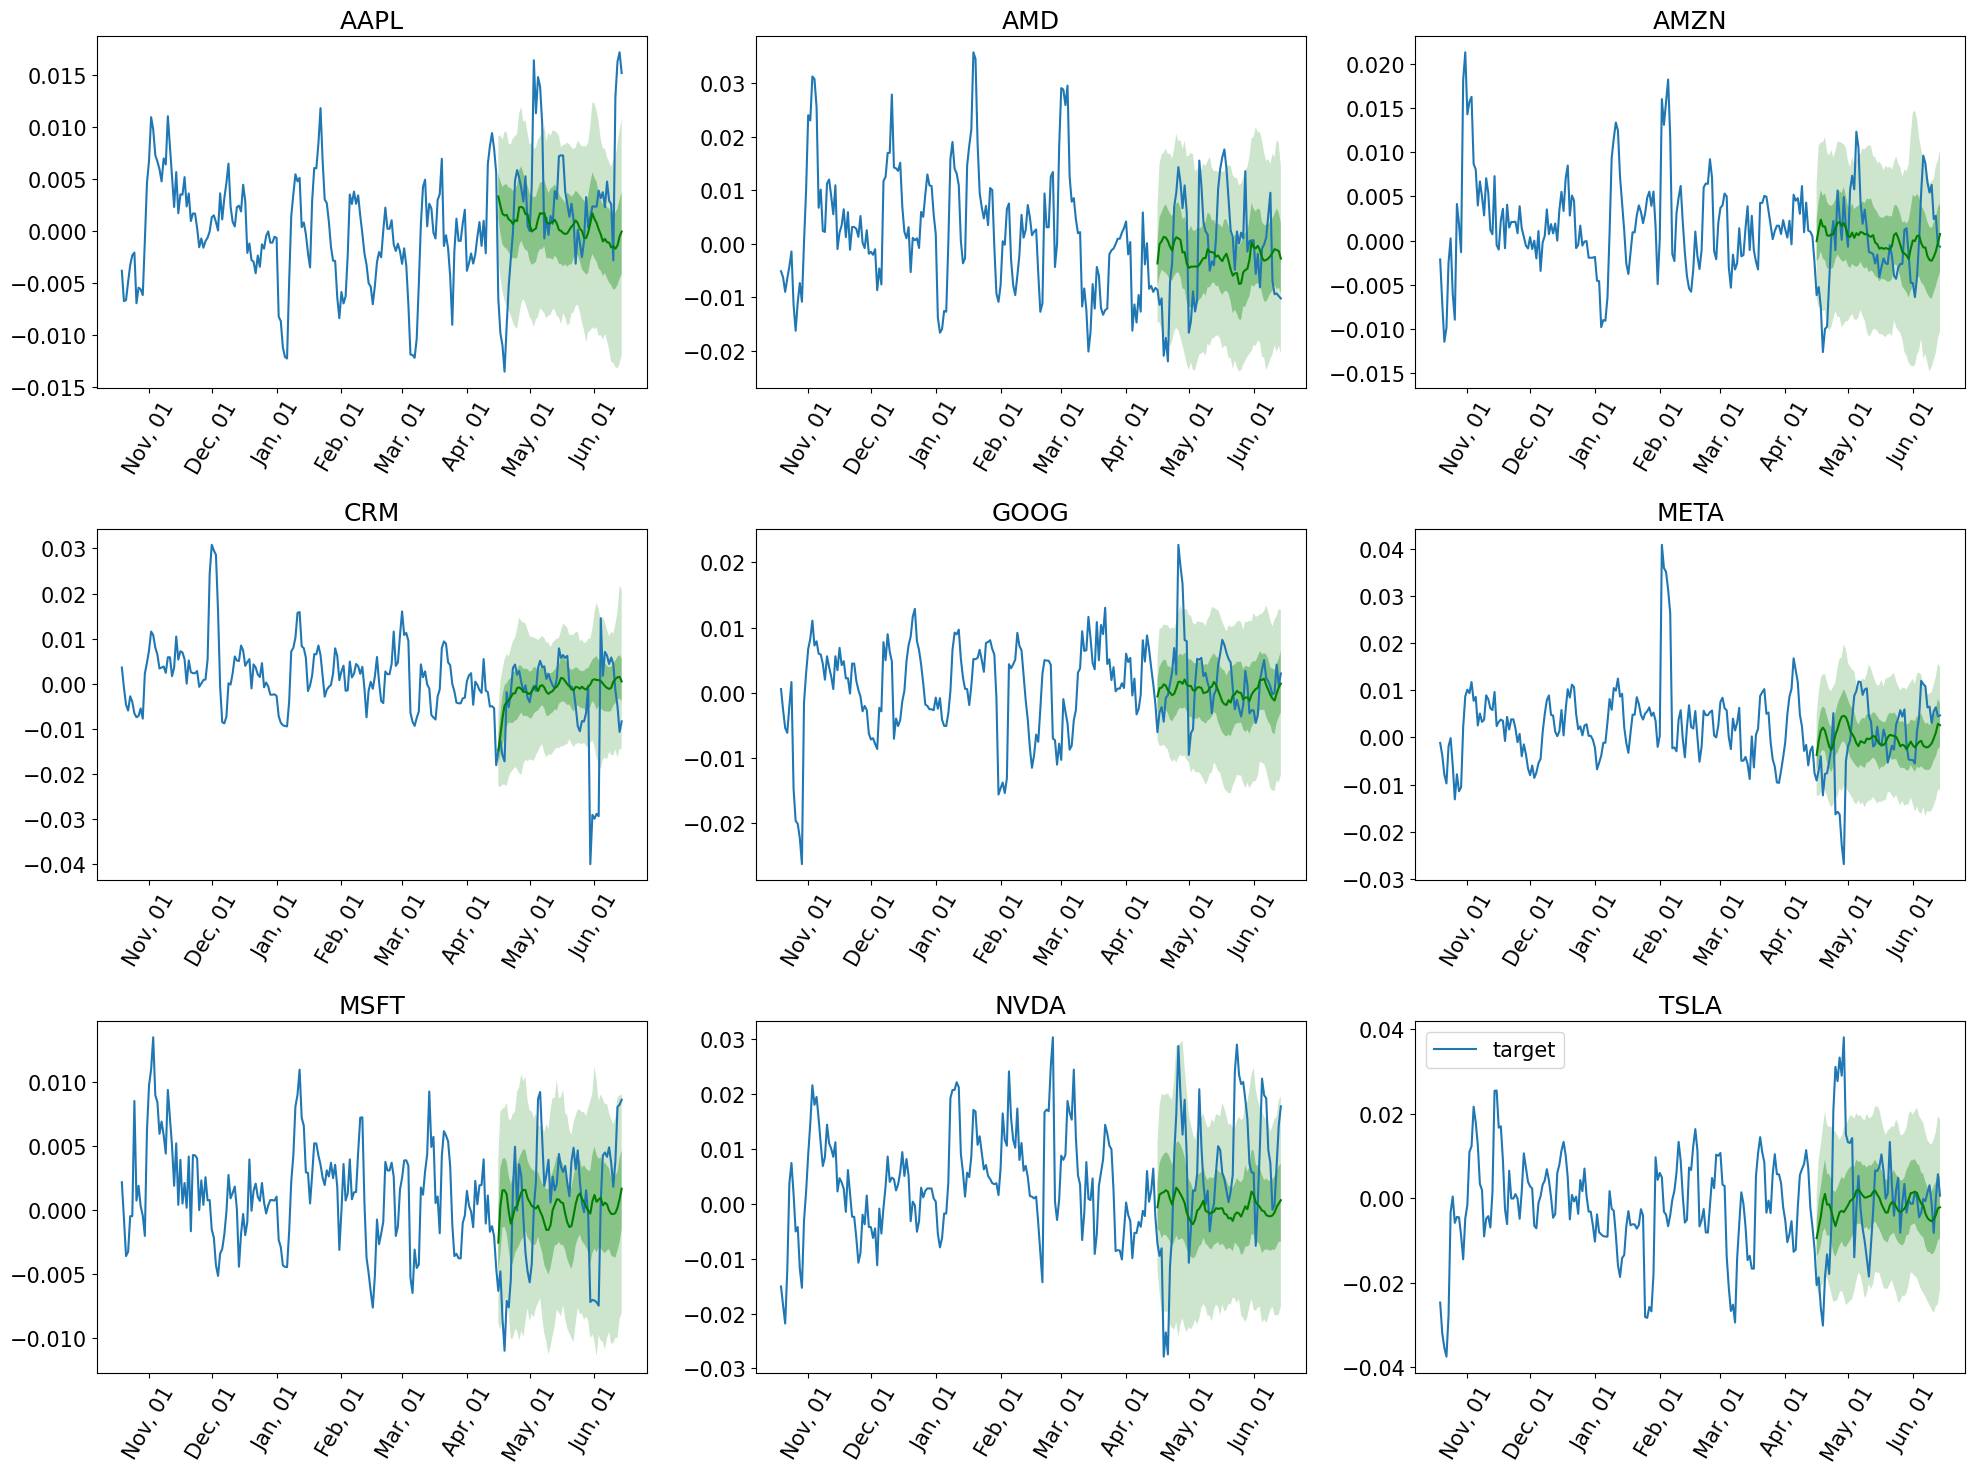

In [149]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [154]:
import numpy as np
import pandas as pd
from gluonts.dataset.util import to_pandas

def calculate_accuracy(forecast, actual):
    correct_predictions = 0
    total_predictions = 0

    # Convert the actual series to numpy array if it's not already
    actual_values = to_pandas(actual).values if isinstance(actual, dict) else np.array(actual)

    # Ensure the lengths match
    forecast_samples = np.mean(forecast.samples, axis=0)
    predicted_movement = np.sign(forecast_samples)
    actual_movement = np.sign(actual_values)

    # Compare predicted and actual movements
    correct_predictions += np.sum(predicted_movement == actual_movement)
    total_predictions += len(actual_values)

    return correct_predictions / total_predictions



for idx in range(0, len(tss)):

    actuals_current = tss[idx][-60:]  # Extract the last 60 values for the current item
    accuracy = calculate_accuracy(forecasts[idx], actuals_current)

    print(f"Prediction Accuracy for item {forecasts[idx].item_id}: {accuracy}")

Prediction Accuracy for item AAPL: 33.85
Prediction Accuracy for item AMD: 28.666666666666668
Prediction Accuracy for item AMZN: 29.5
Prediction Accuracy for item CRM: 33.166666666666664
Prediction Accuracy for item GOOG: 30.533333333333335
Prediction Accuracy for item META: 29.8
Prediction Accuracy for item MSFT: 30.0
Prediction Accuracy for item NVDA: 24.8
Prediction Accuracy for item TSLA: 31.066666666666666


In [51]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 9it [00:00, 247.98it/s]


In [52]:
agg_metrics

{'MSE': 9.727319788739636e-05,
 'abs_error': 3.7460016161203384,
 'abs_target_sum': 3.6032350063323975,
 'abs_target_mean': 0.00667265741913407,
 'seasonal_error': 0.0038593655695295815,
 'MASE': 1.7770539973289647,
 'MAPE': 1.9736088400132539,
 'sMAPE': 1.614683900056062,
 'MSIS': 13.889057898196544,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 1.9412862393073735,
 'Coverage[0.1]': 0.0851851851851852,
 'QuantileLoss[0.2]': 2.8759649273939436,
 'Coverage[0.2]': 0.16296296296296295,
 'QuantileLoss[0.3]': 3.4353463530889705,
 'Coverage[0.3]': 0.22592592592592592,
 'QuantileLoss[0.4]': 3.694574651942821,
 'Coverage[0.4]': 0.3055555555555556,
 'QuantileLoss[0.5]': 3.7460016871773405,
 'Coverage[0.5]': 0.3944444444444445,
 'QuantileLoss[0.6]': 3.5910380031797104,
 'Coverage[0.6]': 0.5037037037037037,
 'QuantileLoss[0.7]': 3.2182139598997312,
 'Coverage[0.7]': 0.6129629629629629,
 'QuantileLoss[0.8]': 2.647673797048628,
 'Coverage[0.8]': 0.7555555555555555,
 'QuantileLoss[0.9]': 1

# fine tuning

In [53]:
ckpt = torch.load("lag-llama.ckpt", map_location="cuda")
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=32,

    # adjust as needed

    # distr_output="neg_bin",
    # scaling="mean",
    nonnegative_pred_samples=True,
    aug_prob=0,
    lr=5e-4,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    time_feat=estimator_args["time_feat"],

    # rope_scaling={
    #     "type": "linear",
    #     "factor": max(
    #         1.0, (context_length + prediction_length) / estimator_args["context_length"]
    #     ),
    # },

    batch_size=64,
    num_parallel_samples=num_samples,
    trainer_kwargs={
        "max_epochs": 50,
    },  # <- lightning trainer arguments
)

In [69]:
# e.g., using the first 11 years of data
# we will then test on the rest of the dataset
train_dataset = _get_lag_llama_dataset(stock_returns.iloc[:252*11])


In [70]:
from gluonts.dataset.util import to_pandas
entry = next(iter(train_dataset))
train_series = to_pandas(entry)
train_series

2013-01-07   -0.009404
2013-01-08   -0.006343
2013-01-09   -0.003764
2013-01-10   -0.001332
2013-01-11   -0.002560
                ...   
2020-08-05    0.007076
2020-08-06    0.014122
2020-08-07    0.009207
2020-08-08    0.004289
2020-08-09    0.002962
Freq: D, Length: 2772, dtype: float32

In [71]:
predictor = estimator.train(
    train_dataset,
    cache_data=True,
    shuffle_buffer_length=1000,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | LagLlamaModel      | 2.4 M 
1 | augmentations | ApplyAugmentat

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached -4.10314 (best -4.10314), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached -4.10314 (best -4.10314), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached -4.37169 (best -4.37169), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached -4.37169 (best -4.37169), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached -4.78808 (best -4.78808), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:light

In [74]:
test_dataset = _get_lag_llama_dataset(stock_returns.iloc[252*11:])
entry = next(iter(test_dataset))
test_series = to_pandas(entry)
test_series

2020-08-10    0.005141
2020-08-11   -0.007722
2020-08-12    0.003416
2020-08-13    0.006993
2020-08-14    0.006762
                ...   
2024-06-10   -0.002803
2024-06-11    0.012951
2024-06-12    0.016328
2024-06-13    0.017227
2024-06-14    0.015227
Freq: D, Length: 1405, dtype: float32

In [76]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_dataset,
        predictor=predictor,
        num_samples=num_samples
    )

In [78]:
forecasts = list(tqdm(forecast_it, total=len(test_dataset), desc="Forecasting batches"))

Forecasting batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [85]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id='AAPL', samples=array([[0.0000000e+00, 1.2152460e-03, 2.9645814e-03, ..., 2.2716164e-04,
        0.0000000e+00, 3.9464958e-05],
       [0.0000000e+00, 1.3611884e-03, 2.9977337e-03, ..., 1.6288775e-04,
        0.0000000e+00, 4.1056695e-04],
       [0.0000000e+00, 1.1111390e-03, 3.1489634e-03, ..., 0.0000000e+00,
        0.0000000e+00, 3.8365350e-05],
       ...,
       [0.0000000e+00, 1.2519429e-03, 3.0645744e-03, ..., 8.0912490e-05,
        0.0000000e+00, 1.7969716e-04],
       [0.0000000e+00, 1.2132308e-03, 3.7097926e-03, ..., 0.0000000e+00,
        0.0000000e+00, 4.2701060e-05],
       [0.0000000e+00, 1.2047871e-03, 3.6106103e-03, ..., 1.0911871e-04,
        0.0000000e+00, 1.1913500e-04]], dtype=float32), start_date=Period('2024-04-16', 'D'))

In [80]:
tss = list(tqdm(ts_it, total=len(test_dataset), desc="Ground truth"))

Ground truth:   0%|          | 0/9 [00:00<?, ?it/s]

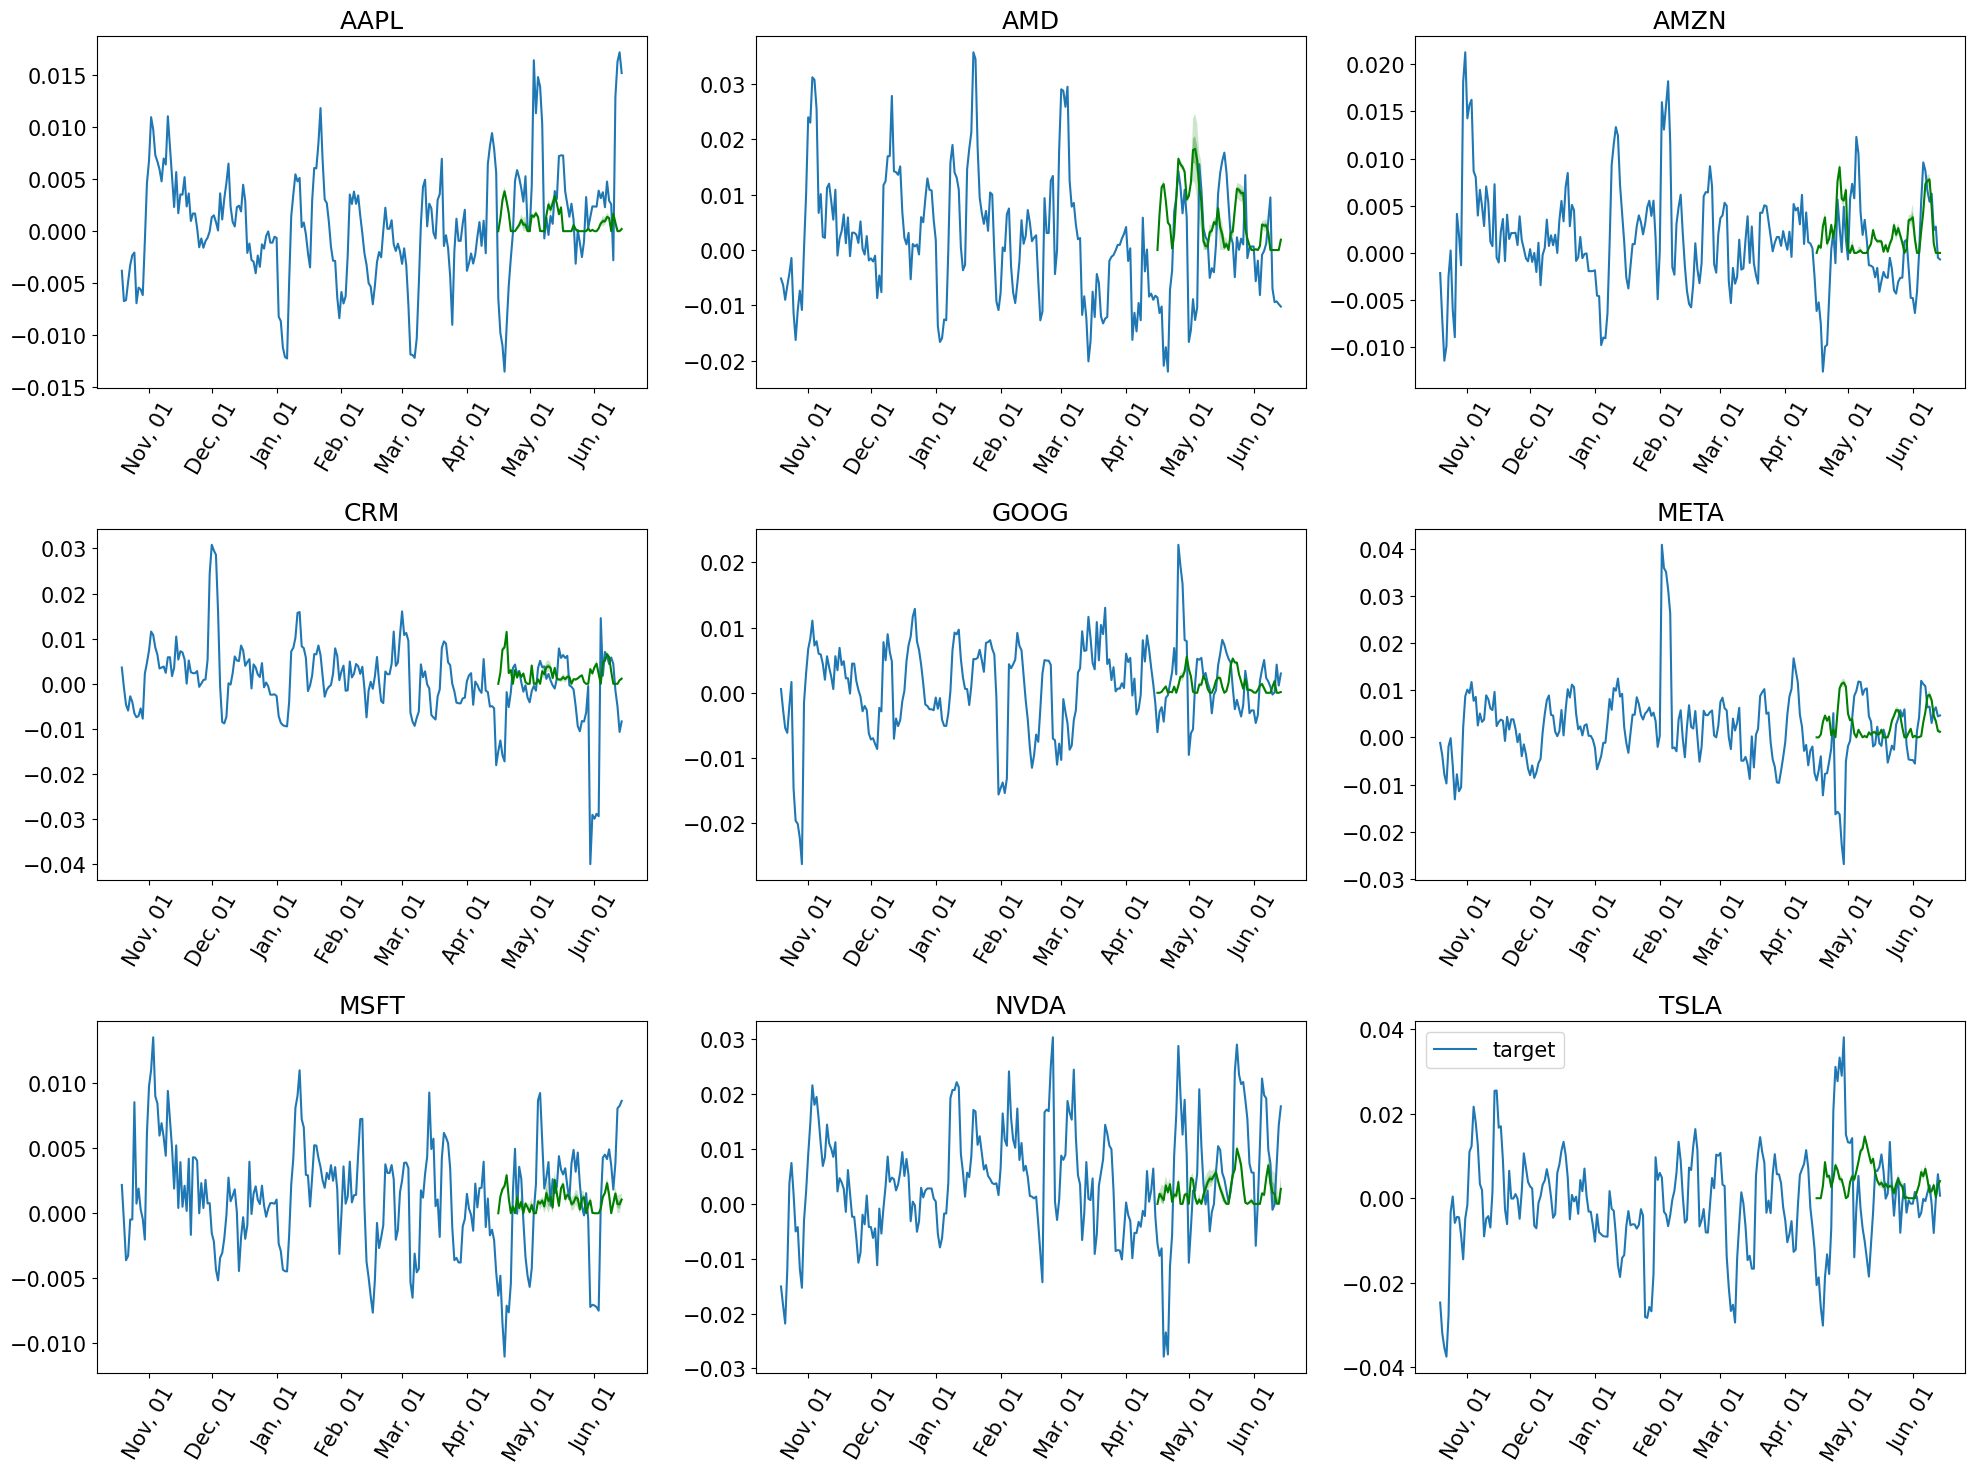

In [143]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):

    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [86]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))
agg_metrics


Running evaluation: 9it [00:00, 307.65it/s]


{'MSE': 0.00010519690177817312,
 'abs_error': 3.8063367754220963,
 'abs_target_sum': 3.6032350063323975,
 'abs_target_mean': 0.00667265741913407,
 'seasonal_error': 0.004355131949066485,
 'MASE': 1.5798837430161068,
 'MAPE': 2.6612446781979813,
 'sMAPE': 1.5631641459779324,
 'MSIS': 57.97415981451239,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 4.2845316987433755,
 'Coverage[0.1]': 0.5185185185185185,
 'QuantileLoss[0.2]': 4.2088285745077885,
 'Coverage[0.2]': 0.5259259259259258,
 'QuantileLoss[0.3]': 4.096418552585964,
 'Coverage[0.3]': 0.5277777777777778,
 'QuantileLoss[0.4]': 3.9614977908873694,
 'Coverage[0.4]': 0.5277777777777778,
 'QuantileLoss[0.5]': 3.8063368086623086,
 'Coverage[0.5]': 0.5314814814814814,
 'QuantileLoss[0.6]': 3.6318883712854584,
 'Coverage[0.6]': 0.5388888888888889,
 'QuantileLoss[0.7]': 3.4382618732393895,
 'Coverage[0.7]': 0.5425925925925926,
 'QuantileLoss[0.8]': 3.223291874944698,
 'Coverage[0.8]': 0.5462962962962963,
 'QuantileLoss[0.9]': 2.9

In [137]:
import numpy as np
import pandas as pd
from gluonts.dataset.util import to_pandas

def calculate_accuracy(forecast, actual):
    correct_predictions = 0
    total_predictions = 0

    # Convert the actual series to numpy array if it's not already
    actual_values = to_pandas(actual).values if isinstance(actual, dict) else np.array(actual)

    # Ensure the lengths match
    forecast_samples = np.mean(forecast.samples, axis=0)
    predicted_movement = np.sign(forecast_samples)
    actual_movement = np.sign(actual_values)

    # Compare predicted and actual movements
    correct_predictions += np.sum(predicted_movement == actual_movement)
    total_predictions += len(actual_values)

    return correct_predictions / total_predictions



for idx in range(0, len(tss)):

    actuals_current = tss[idx][-60:]  # Extract the last 60 values for the current item
    accuracy = calculate_accuracy(forecasts[idx], actuals_current)
    print(f"Prediction Accuracy for item {forecasts[idx].item_id}: {accuracy}")

Prediction Accuracy for item AAPL: 36.833333333333336
Prediction Accuracy for item AMD: 28.8
Prediction Accuracy for item AMZN: 24.3
Prediction Accuracy for item CRM: 23.333333333333332
Prediction Accuracy for item GOOG: 32.3
Prediction Accuracy for item META: 27.9
Prediction Accuracy for item MSFT: 37.333333333333336
Prediction Accuracy for item NVDA: 40.13333333333333
Prediction Accuracy for item TSLA: 24.733333333333334
